# binder/tag MCMC
Author(s): Cody Herron, Mike Pablo


In [18]:
# import required packages
import numpy as np
import scipy.io as sio
import pandas as pd
import scipy as scpy
from scipy.integrate import odeint
from scipy import stats
from pymcmcstat import MCMC
from pymcmcstat import MCMC, structures, plotting, propagation
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat.chain import ChainStatistics
from pymcmcstat import chain
import matlab.engine 
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(over='ignore');

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['font.sans-serif']="Arial"
matplotlib.rcParams['font.family']="sans-serif"

The data is saved in a `.mat` file as the original example comes from the Matlab.  We extract the necessary data as follows

In [19]:
bt_data = sio.loadmat('LL_MCMC/BT_all_exp_data.mat',struct_as_record=True)


In [20]:
data_names = ['tag_codiff','bin_codiff','tag_all','cat','proc_1', 'proc_2', 'proc_3','proc_4']

exp_lft_data = []
exp_lft_x = bt_data['all_exp_data']['tag_codiff'][0][0]['X'][0][0][0]
exp_cat_data = []
exp_cat_x = bt_data['all_exp_data']['cat'][0][0]['X'][0][0][0]
exp_proc_data = []
exp_proc_x = bt_data['all_exp_data']['proc_1'][0][0]['X'][0][0][0]

exp_data = []
exp_x = []
for i,d in enumerate(data_names):
    exp_x.append(bt_data['all_exp_data'][d][0][0]['X'][0][0][0])
    exp_data.append(bt_data['all_exp_data'][d][0][0]['Y'][0][0][0])


# need to pad for pymcstat object
pad = np.max([len(k) for k in exp_data])
exp_data = np.array([np.concatenate([k.flatten(), np.full(pad-len(k), np.nan)]) for k in exp_data])
exp_x =  np.array([np.concatenate([k.flatten(), np.full(pad-len(k), np.nan)]) for k in exp_x])
exp_data = np.array(exp_data).T
exp_x = np.array(exp_x.T)   

# Define Mean Square Error and Model Functions

In [41]:
eng = matlab.engine.start_matlab() 

def BT_mse(params,mc_data):
    
    def mse(A,B):
        A = A[~np.isnan(A)]
        B = B[~np.isnan(B)]
        return(np.mean(np.subtract(A,B)**2))

    ndp, nbatch = mc_data.shape[0]
    exp_lft = np.array(mc_data.ydata).T[:3] 
    exp_cat = np.array(mc_data.ydata).T[3] 
    exp_proc = np.array(mc_data.ydata).T[4:]

    sim_dists = run_BT(params)
    
    # return inf if incorrect shape
    if np.shape(sim_dists) != (75,8) :
        return(np.ones(8)*np.inf)
    
    sim_lft = np.array(sim_dists.T[:3])
    sim_cat =  np.array(sim_dists.T[3])
    sim_proc =  np.array(sim_dists.T[4:])

    mse_lft = [mse(exp_lft[i],sim_lft[i]) for i in range(3)]
    mse_cat = [mse(exp_cat,sim_cat)]
    mse_proc = [mse(exp_proc[i],sim_proc[i]) for i in range(4)]
    return(np.hstack([mse_lft,mse_cat,mse_proc]))


def run_BT(params, data=None):
    params = [float(p) for p in params]
    out = eng.markov_distributions(*params)
    out = [np.asarray(out[i]) for i in range(len(out))]
    
    if len(out)==0:
        return(out)
        
    pad = len(max(out, key=len))
    out = np.array([np.concatenate([d.flatten(), np.full(pad-len(d), np.nan)]) for d in out])
    
    return(np.array(out).T)

In [35]:
# eng.quit()

# Initialize MCMC Object and Setup Simulation
- Define data structure
- Assign parameters and define constraints
- Set simulation options and model settings

In [23]:
# initialize MCMC object
mcstat = MCMC.MCMC()


mcstat.data.add_data_set(x=np.arange(0,75),
                         y=exp_data,
                         user_defined_object=exp_x)

# initialize parameter array
#theta = [5.31,  8.88,  1.39,  2.98,  0.63, 12.1 ,  0.23,  0.15]
# add model parameters
mcstat.parameters.add_model_parameter(name='k1', theta0=5.31, minimum=0)
mcstat.parameters.add_model_parameter(name='k2', theta0=8.88, minimum=0)
# mcstat.parameters.add_model_parameter(name='k3', theta0=1.39, minimum=0)
mcstat.parameters.add_model_parameter(name='k4', theta0=2.98, minimum=0)
mcstat.parameters.add_model_parameter(name='k6', theta0=0.63, minimum=0)
mcstat.parameters.add_model_parameter(name='k7', theta0=12.1, minimum=0)
mcstat.parameters.add_model_parameter(name='k8', theta0=0.23, minimum=0)
mcstat.parameters.add_model_parameter(name='f1', theta0=0.15, minimum=0,maximum=0.76)


# Generate options
mcstat.simulation_options.define_simulation_options(
    nsimu=1.0e1, updatesigma=True, 
    verbosity=False,save_to_json=True,
    save_lightly=False, waitbar=False )
     #save_to_json=True, verbosity=0, waitbar=True, save_to_bin=True)
# Define model object:
mcstat.model_settings.define_model_settings(
    sos_function=BT_mse,
    nbatch = 8,
    sigma2=0.01**2,S20=0.05*np.ones(8),N0=0.05*np.ones(8))

The code takes some time to run, so here we simply check to make sure the data structure can be processed using our sum-of-squares function.  Note, we have separate sum-of-squares for each quantity of interest and there will be a separate error variance for each as well.

In [42]:
# check model evaluation
params = [5.31,  8.88, 2.98,  0.63, 12.1 ,  0.23,  0.15]
mse = BT_mse(params,mcstat.data)
print('EA Best Param Set MSE: ', mse)
print('EA Best Param Set Sum MSE: ', sum(mse))

EA Best Param Set MSE:  [3.07092683e-04 2.20093781e-04 3.73111762e-05 7.58575432e-04
 3.94328330e-04 1.25312519e-04 2.44160412e-04 3.35449069e-04]
EA Best Param Set Sum MSE:  0.0024223234029247783


# Run simulation
- We run an initialize sequence of 1000, then restart and perform another 5000

In [136]:
# Run simulation
mcstat.run_simulation()
# # Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(50)
mcstat.run_simulation(use_previous_results=True)

# Extract results and plot chain diagnostics
- chain panel
- density panel
- pairwise correlation panel

In [8]:
# # extract info from results
# results = mcstat.simulation_results.results
# chain = results['chain']
# s2chain = results['s2chain']
# names = results['names'] # parameter names

# # display chain stats
# # mcstat.chainstats(chain, results)

# mcpl = MCMCPlotting
# # plot chain panel
# mcpl.plot_chain_panel(chain, names, figsizeinches=[7, 6])
# # plot density panel
# mcpl.plot_density_panel(chain, names, figsizeinches=[7, 6])
# # pairwise correlation
# mcpl.plot_pairwise_correlation_panel(chain, names, figsizeinches=[7, 6])

# Generate prediction/credible intervals for each quantity of interest
## Generate intervals

In [139]:
# intervals = propagation.calculate_intervals(results['chain'][10:], results, mcstat.data, run_BT,
#                                                 waitbar=True, nsample=20,s2chain = s2chain[10:])

 [-----------------105%------------------] 21 of 20 complete in 63.6 sec

In [140]:
# def get_MCMC_plot_settings():
#     data_display = dict(marker='o',
#                         color='k',
#                         mfc='none',
#                         label='Data')
#     model_display = dict(color='r')
#     interval_display = dict(alpha=0.5)

#     return data_display, model_display, interval_display

# data_display, model_display, interval_display = get_MCMC_plot_settings()

In [11]:
# for ii, interval in enumerate(intervals):
#         fig, ax = propagation.plot_intervals(interval,
#                                              time=np.array(mcstat.data.user_defined_object).T[ii].T,
#                                              ydata=mcstat.data.ydata[0][:, ii],
#                                              data_display=data_display,
#                                              model_display=model_display,
#                                              interval_display=interval_display,
#                                              legloc='upper right')

# Load in MCMC Runs

In [10]:
chains = []
burn_in_chains = []

#read in output files from MCMC runs
outputfile1 = 'LL_MCMC/MCMCRun20210308_1615218413/MCMCRun20210308_1615218413.json'
outputfile2 = 'LL_MCMC/MCMCRun20210308_1615218457/MCMCRun20210308_1615218457.json'
outputfile3 = 'LL_MCMC/MCMCRun20210308_1615218508/MCMCRun20210308_1615218508.json'


for o in [outputfile1,outputfile2,outputfile3]:
    results = structures.ResultsStructure.ResultsStructure.load_json_object(o)

    
    # Make sure to convert everything to numpy arrays -- not sure this is the best,
    # but fixes some indexing issues that come up when re-loading from json
    for ii, key in enumerate(results):
        results[key] = np.array(results[key])

    chain = results['chain']
    chains.append(chain)
    names = results['names']
    s2chain = results['s2chain']

    settings = dict(
        fig=dict(figsize=(7, 6))
    )
    # plot chain panel

#     mcp = MCMCPlotting
#     mcp.plot_chain_panel(chain, names,figsizeinches=(10,6))
# # #     # plot density panel
# #     mcp.plot_density_panel(chain, names,figsizeinches=(10,10))
# #     # pairwise correlation
#     f = mcp.plot_pairwise_correlation_panel(chain, names,figsizeinches=(15,15))
#     plt.figure(figsize=(10,8))
#     plt.xlabel('MCMC Steps')
#     plt.ylabel('Sum MSEs')
#     plt.title('Summed MSE (or "SS") Chain')
#     # plt.plot(np.sum(s2chain,axis=1))
#     plt.plot(np.sum(results['sschain'],axis=1))
#     plt.hlines(0.0017,0,len(results['sschain']),'red','--')
#     # plt.yscale('log')

#     plt.legend(['MCMC','EA Best Param Set'])
# #     print(results['total_rejected'], results['model_settings'])
#     print(ChainStatistics.chainstats(chain,results=results))

    burn_in_chains.append(chain[-5000:])
    print(ChainStatistics.chainstats(chain[-5000:],results=results))



------------------------------
      name:      mean       std    MC_err       tau    geweke
        k1:      5.67      3.24      0.52    318.17      0.66
        k2:     12.70      3.95      0.49     71.60      1.00
        k4:      2.36      0.84      0.14    198.40      0.37
        k6:      1.19      0.80      0.14    193.16      0.27
        k7:      9.35      2.52      0.35    152.15      0.71
        k8:      0.19      0.06      0.01    323.54      0.42
        f1:      0.53      0.14      0.02     98.11      0.86
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 7.34%
Stage 2: 12.69%
Net    : 20.03% -> 2003/10000
---------------
Chain provided:
Net    : 18.50% -> 925/5000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------
None


------------------------------
      n

In [12]:
burn_in_chains = np.array(burn_in_chains)

In [13]:
gr = ChainStatistics.gelman_rubin(burn_in_chains)

Parameter: $p_{0}$
  R = 1.0874323598379205
  B = 13086.53949536877
  W = 19.09999641221391
  V = 22.58592027836314
  neff = 25.888341550899835
Parameter: $p_{1}$
  R = 1.007557591475958
  B = 880.8589731984276
  W = 15.280454065705733
  V = 15.512293701078839
  neff = 264.1562526987696
Parameter: $p_{2}$
  R = 1.0102674315289053
  B = 54.5597268554738
  W = 0.6981316112441348
  V = 0.712541245416679
  neff = 195.89758412028925
Parameter: $p_{3}$
  R = 1.0090204705367447
  B = 43.94903269285285
  W = 0.6396432587162763
  V = 0.6512350721159604
  neff = 222.26942171876286
Parameter: $p_{4}$
  R = 1.0270173503287099
  B = 1693.0523078085164
  W = 8.214019647186042
  V = 8.66385745867221
  neff = 76.75950783133237
Parameter: $p_{5}$
  R = 1.0273869663282167
  B = 0.4117500601847852
  W = 0.001970426714766655
  V = 0.0020798326454729787
  neff = 75.76802701156588
Parameter: $p_{6}$
  R = 1.016169125802933
  B = 2.2778747173747473
  W = 0.018519480415021185
  V = 0.019123209776904782
  neff

In [15]:
print('Gelman-Rubin Diagnostic: ')
for key in gr.keys():
    print(gr[key]['R'])

Gelman-Rubin Diagnostic: 
1.0874323598379205
1.007557591475958
1.0102674315289053
1.0090204705367447
1.0270173503287099
1.0273869663282167
1.016169125802933


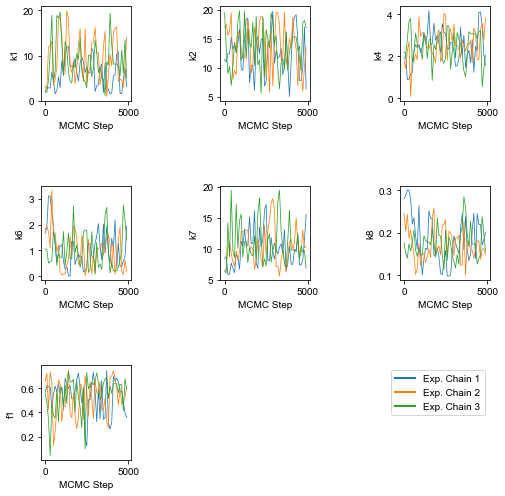

In [17]:
from matplotlib.lines import Line2D

colors = sns.color_palette('tab10')
burn_in_chains = np.array(burn_in_chains)

# plt.figure(figsize=(4,2.5)) # for final figure
plt.figure(figsize=(7,7))

for i in range(np.shape(burn_in_chains)[2]):
    plt.subplot(3,3,i+1)
    plt.ylabel(names[i])
    plt.xlabel('MCMC Step')
    for j in range(np.shape(burn_in_chains)[0]):
        x,y = range(len(burn_in_chains[j,:,i])),burn_in_chains[j,:,i].flatten()
        plt.plot(x[::100],y[::100],lw=0.75,color=colors[j])
    plt.tight_layout()
        


custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
            Line2D([0], [0], color=colors[1], lw=2),
            Line2D([0], [0], color=colors[2], lw=2)]

plt.subplot(3,3,9)
plt.axis('off')
plt.legend(custom_lines, ['Exp. Chain 1','Exp. Chain 2','Exp. Chain 3'])
# plt.tight_layout()
plt.subplots_adjust(wspace=1, hspace=0.9)
        
# plt.savefig('MCMC_Chains_Exp.pdf',dpi=300,bbox_inches = "tight",transparent=True)

In [10]:

# plt.figure(figsize=(10,10))
# plt.title('From MCMC Runs')
# plt.ylim([0,20])
# plt.xlim([0,20])
# for i in range(3):
#     x,y = chains[i].T[0],chains[i].T[1]
#     plt.scatter(x,y,alpha=0.3)

# plt.legend(['Run 1', 'Run 2', 'Run 3'])    
# for i in range(3):
#     x,y = chains[i].T[0],chains[i].T[1]
#     coef = np.polyfit(x,y,1)
#     print('M = %.2f, b = %.2f' %(coef[0],coef[1]))
#     print('Pearson: %.2f'%stats.pearsonr(x,y)[0])
#     poly1d_fn = np.poly1d(coef) 
#     plt.plot(x, poly1d_fn(x), '-.k')
#     plt.xlabel('k1')
#     plt.ylabel('k2')
    
# plt.tight_layout()
# # plt.savefig('k1vk2.png',dpi=150)

    


In [11]:
# plt.figure(figsize=(10,10))
# plt.title('k1/(k1+k2)')

# for i in range(3):
#     x,y = chains[i].T[0],chains[i].T[1]
#     plt.scatter(x,x/(x+y),alpha=0.3)
#     plt.ylabel('k1/(k1+k2)')
#     plt.xlabel('k1')
    

In [106]:
from heatmap import heatmap, corrplot
import pandas as pd

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# %load_ext autoreload
# %autoreload 2

In [294]:
chain_df = pd.DataFrame(np.vstack(burn_in_chains),columns = names)

chain_i = np.hstack([np.ones(5000), 2*np.ones(5000), 3*np.ones(5000)])
chain_df['Chain'] = chain_i
chain_df.to_csv('Exp_Chains.csv')

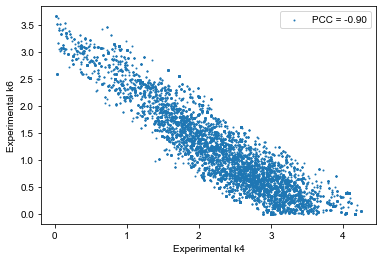

In [43]:
all_data = np.vstack(burn_in_chains).T

# plt.figure(figsize = (2.5,2)) #for final figure
plt.figure()
plt.scatter(all_data[2],all_data[3],s=1)
plt.ylabel('Experimental k6')
plt.xlabel('Experimental k4')

pcc = scpy.stats.pearsonr(all_data[2],all_data[3])[0]
plt.legend(['PCC = %.2f'%pcc])

# plt.savefig('MCMC_Chains_Exp_k4k6.pdf',bbox_inches = 'tight',dpi=300,transparent=True)



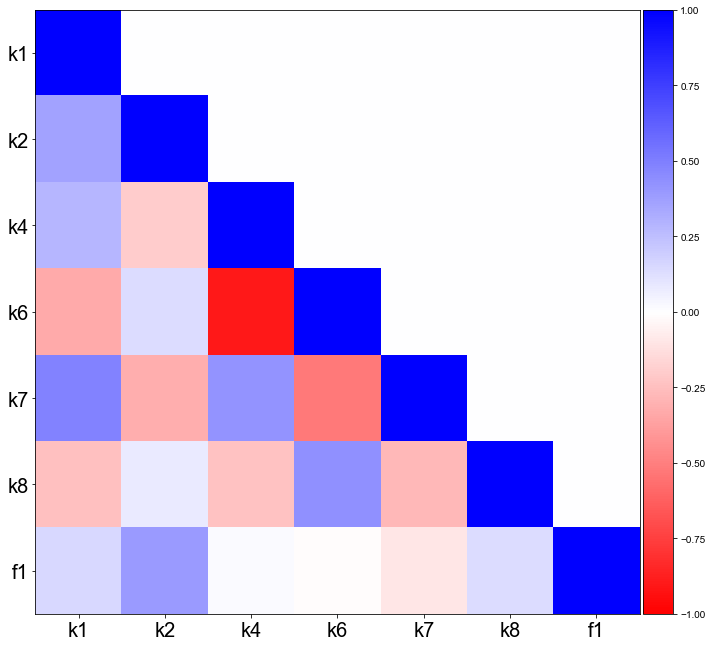

In [68]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10,10))
corr = np.corrcoef(np.vstack(burn_in_chains).T)
corr = np.tril(corr,k=0)
im = plt.imshow(corr,cmap=plt.cm.bwr_r, vmin=-1,vmax=1)
plt.xticks(range(7),names)
plt.yticks(range(7),names)

ax = plt.gca()

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.tight_layout()
# plt.savefig('MCMC_Corr_matrix.png',dpi=150)

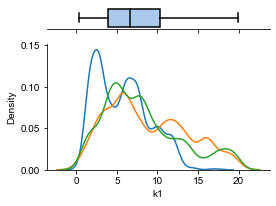

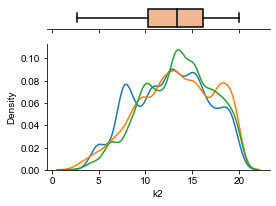

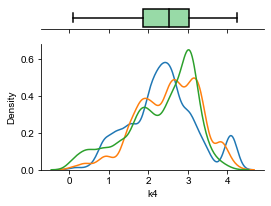

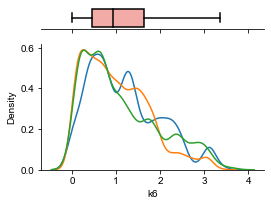

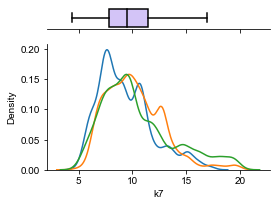

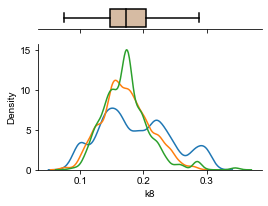

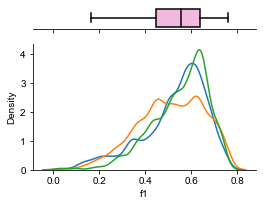

In [44]:
import seaborn as sns
colors= sns.color_palette('tab10')

for i in range(7):
    f, (ax_box, ax_hist) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios': [.15,.85]},figsize=(4.,3.))
    
    sns.boxplot(x=np.vstack(burn_in_chains).T[i],color=sns.color_palette('pastel')[i],ax=ax_box,showfliers=False)
    
    for box in ax_box.artists:
        box.set_edgecolor('black')

        # iterate over whiskers and median lines
        for k in range(0,5):
            ax_box.lines[k].set_color('black')
    
    for j in range(len(burn_in_chains)):
        sns.kdeplot(ax=ax_hist,x = burn_in_chains[j].T[i],color=colors[j])

    ax_hist.set_xlabel(names[i])
    ax_box.set(yticks=[])

    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    sns.despine(ax=ax_box, left=True)
#     plt.tight_layout()
#     plt.savefig('Figures/KDE_BP_%s.png' %names[i],dpi=300,bbox_inches='tight')
    


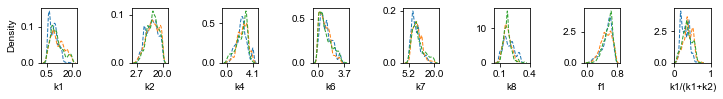

In [48]:
from matplotlib.lines import Line2D

# plt.figure(figsize=(9,0.8)) #for final figure
plt.figure(figsize = (12,1))

for i in range(np.shape(burn_in_chains)[2]):

    
    plt.subplot(1,8,i+1)

        

    plt.xlabel(names[i],y=0.95)
    all_data = np.vstack(burn_in_chains[j].T[i])
    for j in range(np.shape(burn_in_chains)[0]):
        sns.kdeplot(x = burn_in_chains[j].T[i],color=colors[j],ls='--',lw=1)
    plt.ylabel(None)
    if i == 0:
        plt.ylabel("Density")
    ax = plt.gca()
    ax.set_xticks([np.around(np.min(all_data),1),np.around(np.max(all_data),1)])

# plt.tight_layout()
        


custom_lines = [Line2D([0], [0], color=colors[0], ls='--',lw=2),
            Line2D([0], [0], color=colors[1], ls='--',lw=2),
            Line2D([0], [0], color=colors[2], ls='--',lw=2)]


plt.subplot(1,8,8)
ratio = np.hstack(burn_in_chains.T[0]/(burn_in_chains.T[0]+burn_in_chains.T[1]))
# sns.boxplot(x=ratio, ax=ax_box_1,showfliers=False)

# # sns.boxplot(x=np.vstack(chains_burnin[1:].T[1]/burn_in_chains[1:].T[0]), ax=ax_box_2,showfliers=False,color='red')

for j in [0,1,2]:
    sns.kdeplot(x = (burn_in_chains[j].T[0]/(burn_in_chains[j].T[0]+burn_in_chains[j].T[1])),color=colors[j],lw=1,ls='--')

plt.ylabel(None)
plt.xlim([0,1])
plt.xlabel('k1/(k1+k2)')



# plt.legend(custom_lines, ['Exp. Chain 1','Exp. Chain 2','Exp. Chain 3'],bbox_to_anchor=(0,1), loc='center right',ncol=1)
plt.subplots_adjust(wspace=1.5, hspace=2)
        
# plt.savefig('MCMC_Param_Dens_Exp.pdf',dpi=300,bbox_inches = "tight",transparent=True)

In [293]:
# Parameter Quantile Stats

print('Median and IQR')
for i,row in enumerate(np.vstack(burn_in_chains).T):
    print(names[i],": ",np.around(np.median(row),3),'s⁻¹',np.around(np.quantile(row,[0.25,0.75]),3))
    
# Mean + stdev
print('Mean and SD')
for i,row in enumerate(np.vstack(burn_in_chains).T):
    print(names[i],": ",np.around(np.mean(row),3),u"\u00B1",np.around(np.std(row),3), 's⁻¹' )


Median and IQR
k1 :  6.577 s⁻¹ [ 3.943 10.348]
k2 :  13.395 s⁻¹ [10.278 16.17 ]
k4 :  2.513 s⁻¹ [1.861 3.038]
k6 :  0.939 s⁻¹ [0.452 1.625]
k7 :  9.537 s⁻¹ [ 7.817 11.469]
k8 :  0.173 s⁻¹ [0.147 0.204]
f1 :  0.556 s⁻¹ [0.448 0.637]
Mean and SD
k1 :  7.494 ± 4.565 s⁻¹
k2 :  13.173 ± 3.924 s⁻¹
k4 :  2.4 ± 0.84 s⁻¹
k6 :  1.106 ± 0.803 s⁻¹
k7 :  9.997 ± 2.905 s⁻¹
k8 :  0.178 ± 0.045 s⁻¹
f1 :  0.531 ± 0.137 s⁻¹


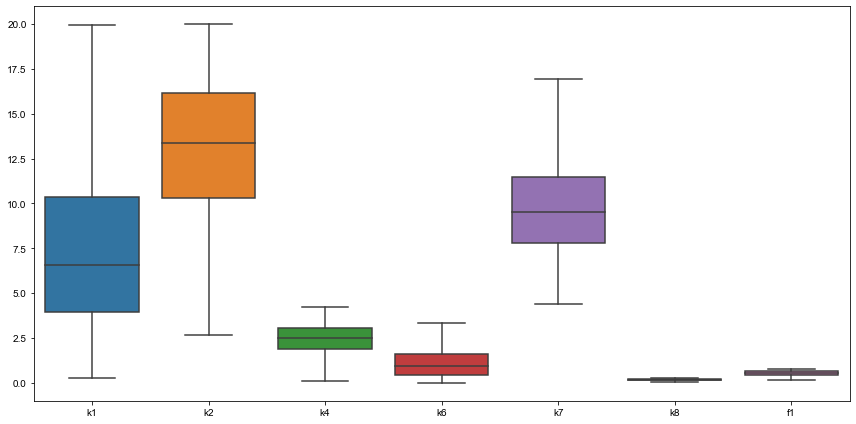

In [292]:
all_xs = []
for i in range(len(burn_in_chains[0].T)):
    y = np.vstack(burn_in_chains).T[i]
    all_xs.append(i*np.ones(len(y)))
all_xs = np.array(all_xs)

plt.figure(figsize=(12.,6.))

flierprops = dict(marker='.', markerfacecolor='k', markersize=5,
                  linestyle='none',alpha=0.3)

x = all_xs.T.flatten()
y = np.vstack(burn_in_chains).flatten()
sns.boxplot(x = x, y = y,showfliers=False,flierprops=flierprops)
plt.xticks(range(7),names)

plt.tight_layout()

# plt.savefig('Figures/BPParams.png',dpi=300,bbox_inches='tight')


In [239]:
import pickle

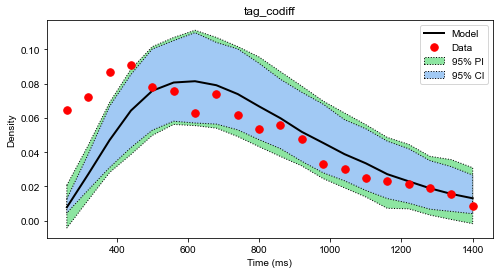

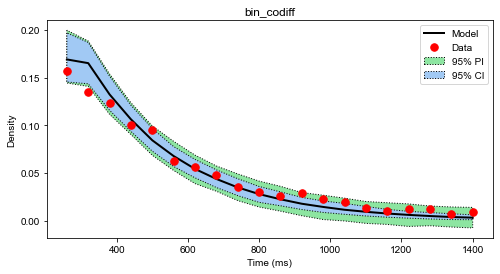

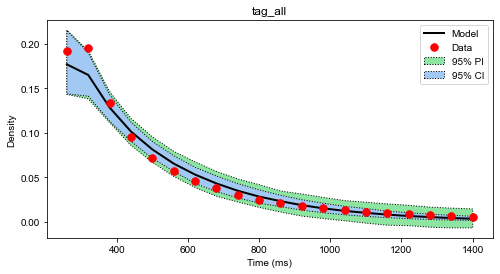

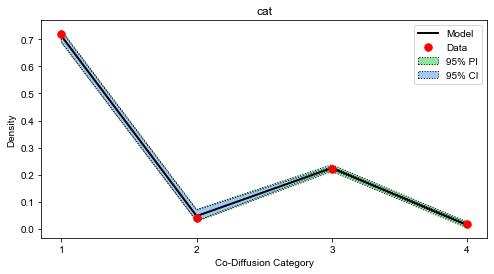

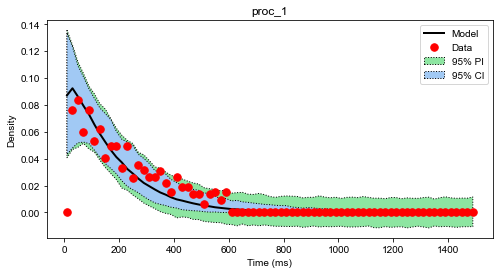

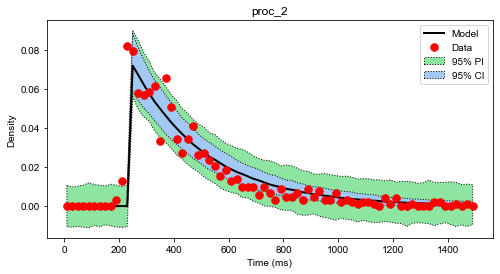

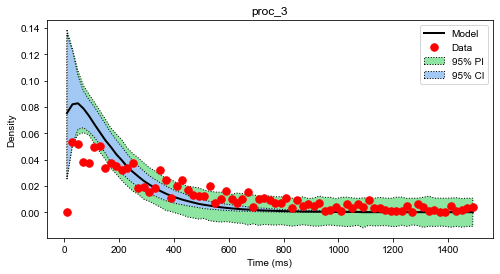

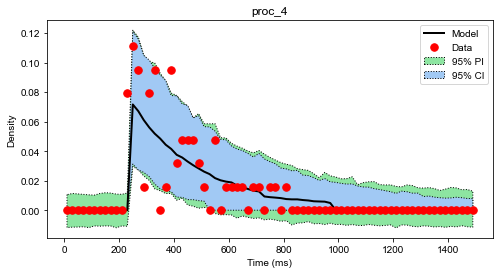

In [258]:

#0.045 Fixed k3 Longer Run
intervalfile1 = 'LL_MCMC/MCMCRun20210308_1615218413/20210308_1615218413_Intervals_k3.pickled'
intervalfile2 = 'LL_MCMC/MCMCRun20210308_1615218457/20210308_1615218457_Intervals_k3.pickled'
intervalfile3 = 'LL_MCMC/MCMCRun20210308_1615218508/20210308_1615218508_Intervals_k3.pickled'

intervalfiles = [intervalfile1,intervalfile2,intervalfile3]


# intervals = [pickle.load(open(f,'rb')) for f in intervalfiles]
intervals = pickle.load(open(intervalfile1,'rb'))


colors = sns.color_palette('pastel')
colors = colors.as_hex()

for ii, interval in enumerate(intervals):
#         fig, ax = propagation.plot_intervals(interval, figsize = (8,4),
#                                              time=np.array(mcstat.data.user_defined_object).T[ii].T,
#                                              data_display=dict(color='r',markersize=7),
#                                              ciset=dict(colors=['#c7e9b4']),
#                                              piset=dict(colors=['#225ea8']),
#                                              ydata=mcstat.data.ydata[0][:, ii],
#                                              legloc='upper right')

        fig, ax = propagation.plot_intervals(interval, figsize = (8,4),
                                             time=np.array(mcstat.data.user_defined_object).T[ii].T,
                                             data_display=dict(color='r',markersize=15),
                                             ciset=dict(colors=[colors[0]]),
                                             piset=dict(colors=[colors[2]]),
                                             ydata=mcstat.data.ydata[0][:, ii],
                                             legloc='upper right')
        plt.title(data_names[ii])
        if ii != 3:
            plt.xlabel('Time (ms)')
        else: 
            plt.xlabel('Co-Diffusion Category')
            plt.xticks([1,2,3,4])
        plt.ylabel('Density')
        